### Input Validation
- Test import the data
- Identify the structure of the data
- Check for anomalies and decide how to proceed with later analysis

In [1]:
import helper
import os
import pandas as pd


# All files from teslamotorsinc-my.sharepoint.com are placed under energy_data
# in this project. These files are provided seprately.
DATA_FILE_LOCATION = os.path.join(os.getcwd(), "energy_data")

In [2]:
# Gather data filenames for import from the file system
signal_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "signals_data" in f]
alert_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "alerts_data" in f]

if len(signal_filenames)==0 or len(alert_filenames)==0:
    raise Exception("ERROR: CSV data files were not found. These should be added under /energy_data")

# Import signals and alerts from all the files into dataframes.
# There is not much data so this should be okay
# Otherwise I would tackle this day by day, as pandas is all in-memory
signal_df = helper.import_csv_files(DATA_FILE_LOCATION, signal_filenames)
alert_df = helper.import_csv_files(DATA_FILE_LOCATION, alert_filenames)

In [3]:
# Compare the date of the file to the date of the data

# Extract the date from the filename
# Example file name: Tesla_SEIA_analyst_signals_data_'2022-03-12'_'LM_handleNegCoreTempDegC'.csv
signal_df["file_date"] = pd.to_datetime(
    signal_df["input_file"].apply( lambda x: x.split("'")[1] )
)

# Datetime convert the raw timestamp
signal_df["datetime_timestamp"] = pd.to_datetime(
    signal_df['timestamp'], unit='ms'
)


<AxesSubplot:xlabel='datetime_timestamp'>

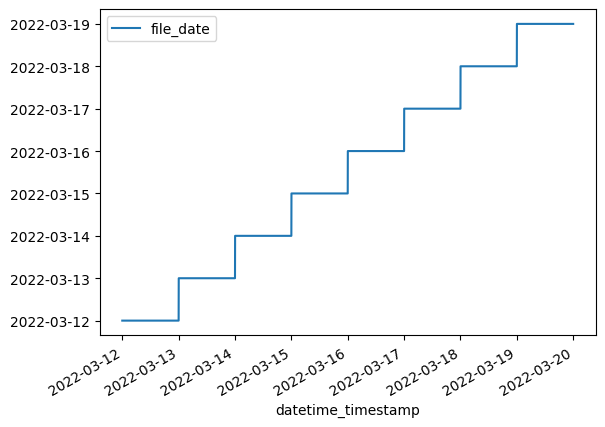

In [4]:
# Plot for comparison of data points aligned with file dates
signal_df.plot(x='datetime_timestamp', y=['file_date', 'event_date'])

In [5]:
# Data points breaking down by the site/asset/component/signal structure
signal_df[['SITE', 'ASSET', 'COMPONENT', 'signal_name', 'VALUE']].groupby(['SITE', 'ASSET', 'COMPONENT', 'signal_name']).count()

VALUE
SITE        ASSET       COMPONENT   signal_name                    
-2073653851 -2126066089 -683919161  LM_handleNegCoreTempDegC   4983
                                    LM_handlePosCoreTempDegC   4983
                                    LM_pcbaTempDegC            4956
                                    LM_powerLimit              9748
                        -46972795   LM_handleNegCoreTempDegC   7363
...                                                             ...
 1919099272 -292580199   935388565  LM_powerLimit              4163
                         1500536224 LM_handleNegCoreTempDegC    560
                                    LM_handlePosCoreTempDegC    560
                                    LM_pcbaTempDegC             559
                                    LM_powerLimit              1105

[788 rows x 1 columns]

In [6]:
# What kind of data do we have?

for thing in ['SITE', 'ASSET', 'COMPONENT', 'signal_name']:
    print(f"Unique {thing}(s): {len(pd.unique(signal_df[thing]))}")

Unique SITE(s): 49
Unique ASSET(s): 51
Unique COMPONENT(s): 197
Unique signal_name(s): 4


In [7]:
# Explore the range of signal values we can expect
signal_df[['signal_name', 'VALUE']].groupby('signal_name').agg(['min', 'mean', 'std', 'max', 'count'])

VALUE                                     \
                                 min        mean        std         max   
signal_name                                                               
LM_handleNegCoreTempDegC -184.790362   48.627901  10.443834  117.938635   
LM_handlePosCoreTempDegC   11.943185   48.812057  10.431065  105.643594   
LM_pcbaTempDegC            18.259663   49.003554   8.319154   74.789010   
LM_powerLimit              20.000015  100.818233  51.484000  406.488359   

                                   
                            count  
signal_name                        
LM_handleNegCoreTempDegC  1840442  
LM_handlePosCoreTempDegC  1840442  
LM_pcbaTempDegC           1834116  
LM_powerLimit             3582164

### Let's plot some data

signal_name
LM_handleNegCoreTempDegC    AxesSubplot(0.125,0.11;0.775x0.77)
LM_handlePosCoreTempDegC    AxesSubplot(0.125,0.11;0.775x0.77)
LM_pcbaTempDegC             AxesSubplot(0.125,0.11;0.775x0.77)
LM_powerLimit               AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

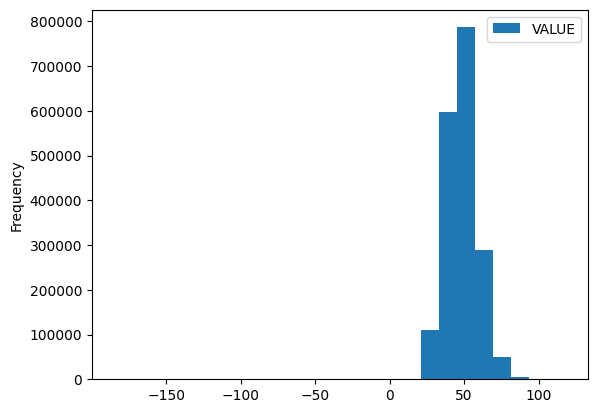

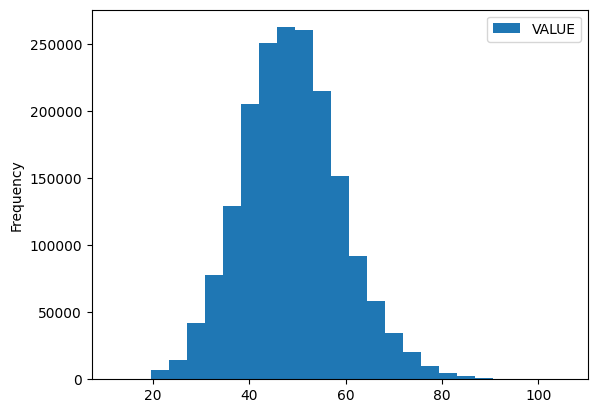

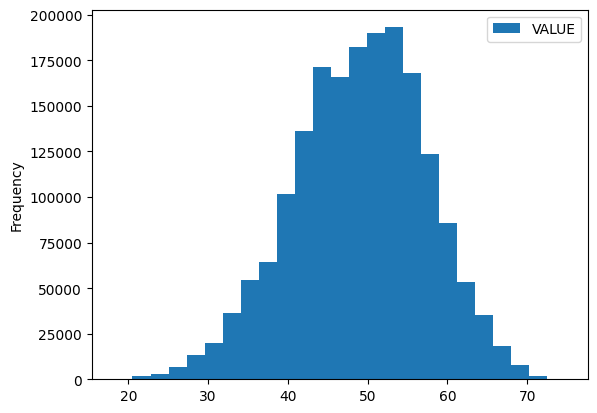

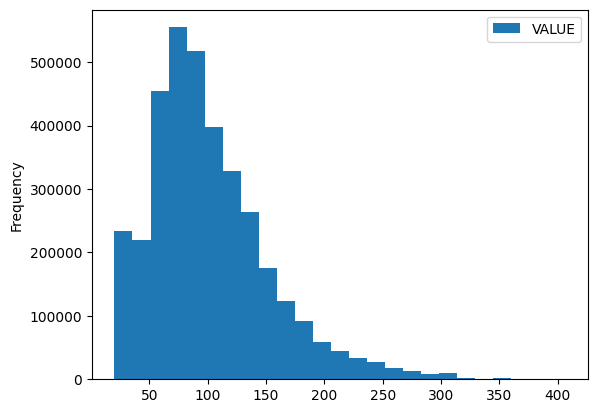

In [8]:
# Look at signals in aggregate
signal_df[['signal_name','VALUE']].groupby('signal_name').plot.hist(by='VALUE', bins=25)

Temperature values below 50 degC are not likely real. This shows up with LM_handleNegCoreTempDegC and skews the histogram.

array([<AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>], dtype=object)

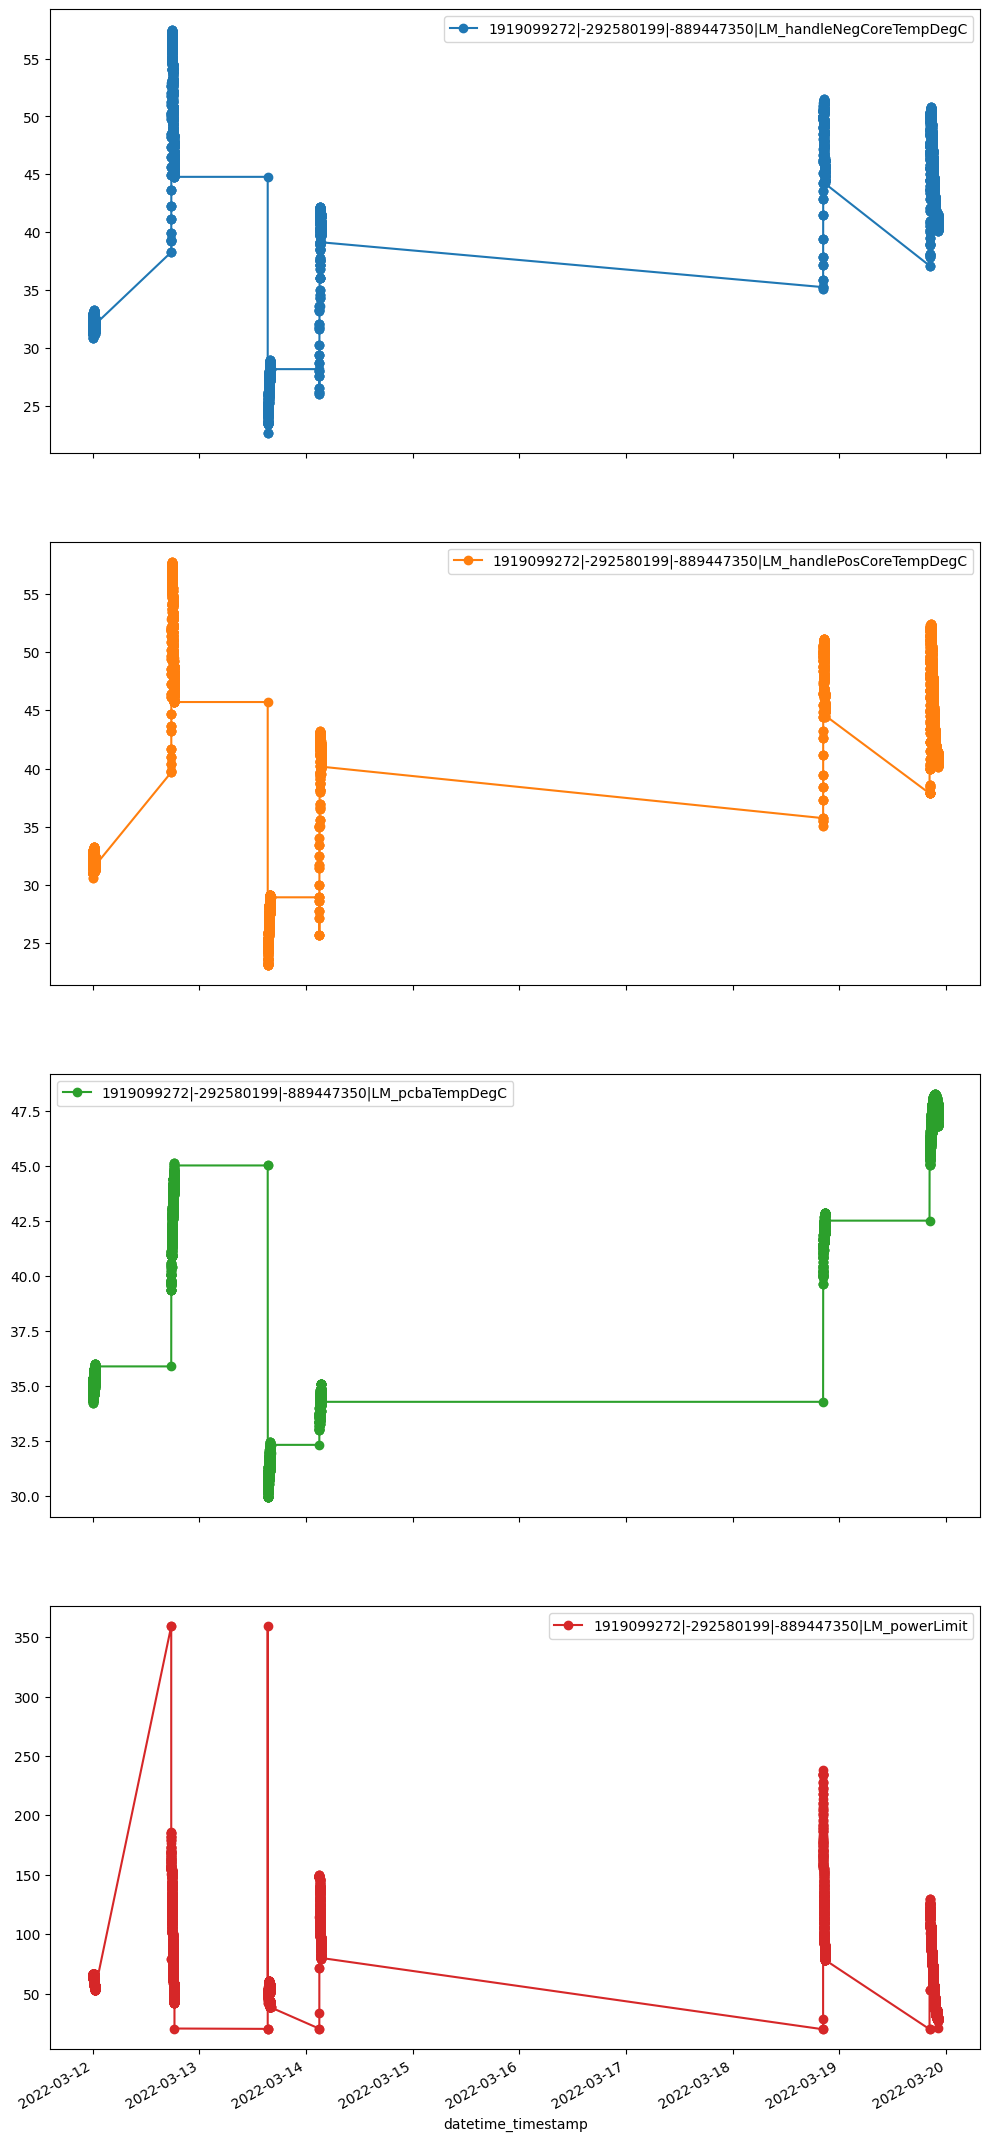

In [9]:
# Look at specific time series data

# Concatenate site/asset/component/signal to get an identifier for plottable signals
signal_df["unique_signal"] = signal_df.apply(lambda x: "|".join([str(x['SITE']), str(x['ASSET']), str(x['COMPONENT']), str(x['signal_name'])]), axis=1)


# Pivot to get a column for a "signal" that shares a timestamp across signals
# By experimentation I chose one SITE/ASSET/COMPONENT that had interesting data

example_component_df = signal_df[
      (signal_df['SITE']==1919099272) 
    & (signal_df['ASSET']==-292580199)
    & (signal_df['COMPONENT']==-889447350)
]

pd.pivot_table(example_component_df,
               index='datetime_timestamp', 
               columns=['unique_signal'],

               values='VALUE').ffill().plot(subplots=True, marker="o", figsize=(12,30))

### Summary:
- Timestamps are likely in UTC time and each file has a day worth of data for a signal in UTC
- We have data from 49 sites, 51 assets, 197 components unique by an id number that is sometimes negative
- There are 4 different signals
- LM_handleNegCoreTempDegC probably has an outlier or invalid value at -184.790362
    - We should probably filter this out for some processing tasks
- We have 8 days worth of data for these signals/assets

In [10]:
# Find the examples of where we have irrational temperature below 63 degC
# We need to decide how to handle it

(
    signal_df[['SITE', 'ASSET', 'COMPONENT', 'signal_name', 'VALUE']][(signal_df["VALUE"]<-63.0) & (signal_df["signal_name"].str.contains("TempDegC"))]
    .groupby(['SITE', 'ASSET', 'COMPONENT', 'signal_name']).agg(['min', 'max', 'count'])
)

VALUE  \
                                                                  min   
SITE       ASSET      COMPONENT  signal_name                            
1524600080 -848050549 1396988257 LM_handleNegCoreTempDegC -184.790362   

                                                                             
                                                                  max count  
SITE       ASSET      COMPONENT  signal_name                                 
1524600080 -848050549 1396988257 LM_handleNegCoreTempDegC -152.575447    71

array([<AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>], dtype=object)

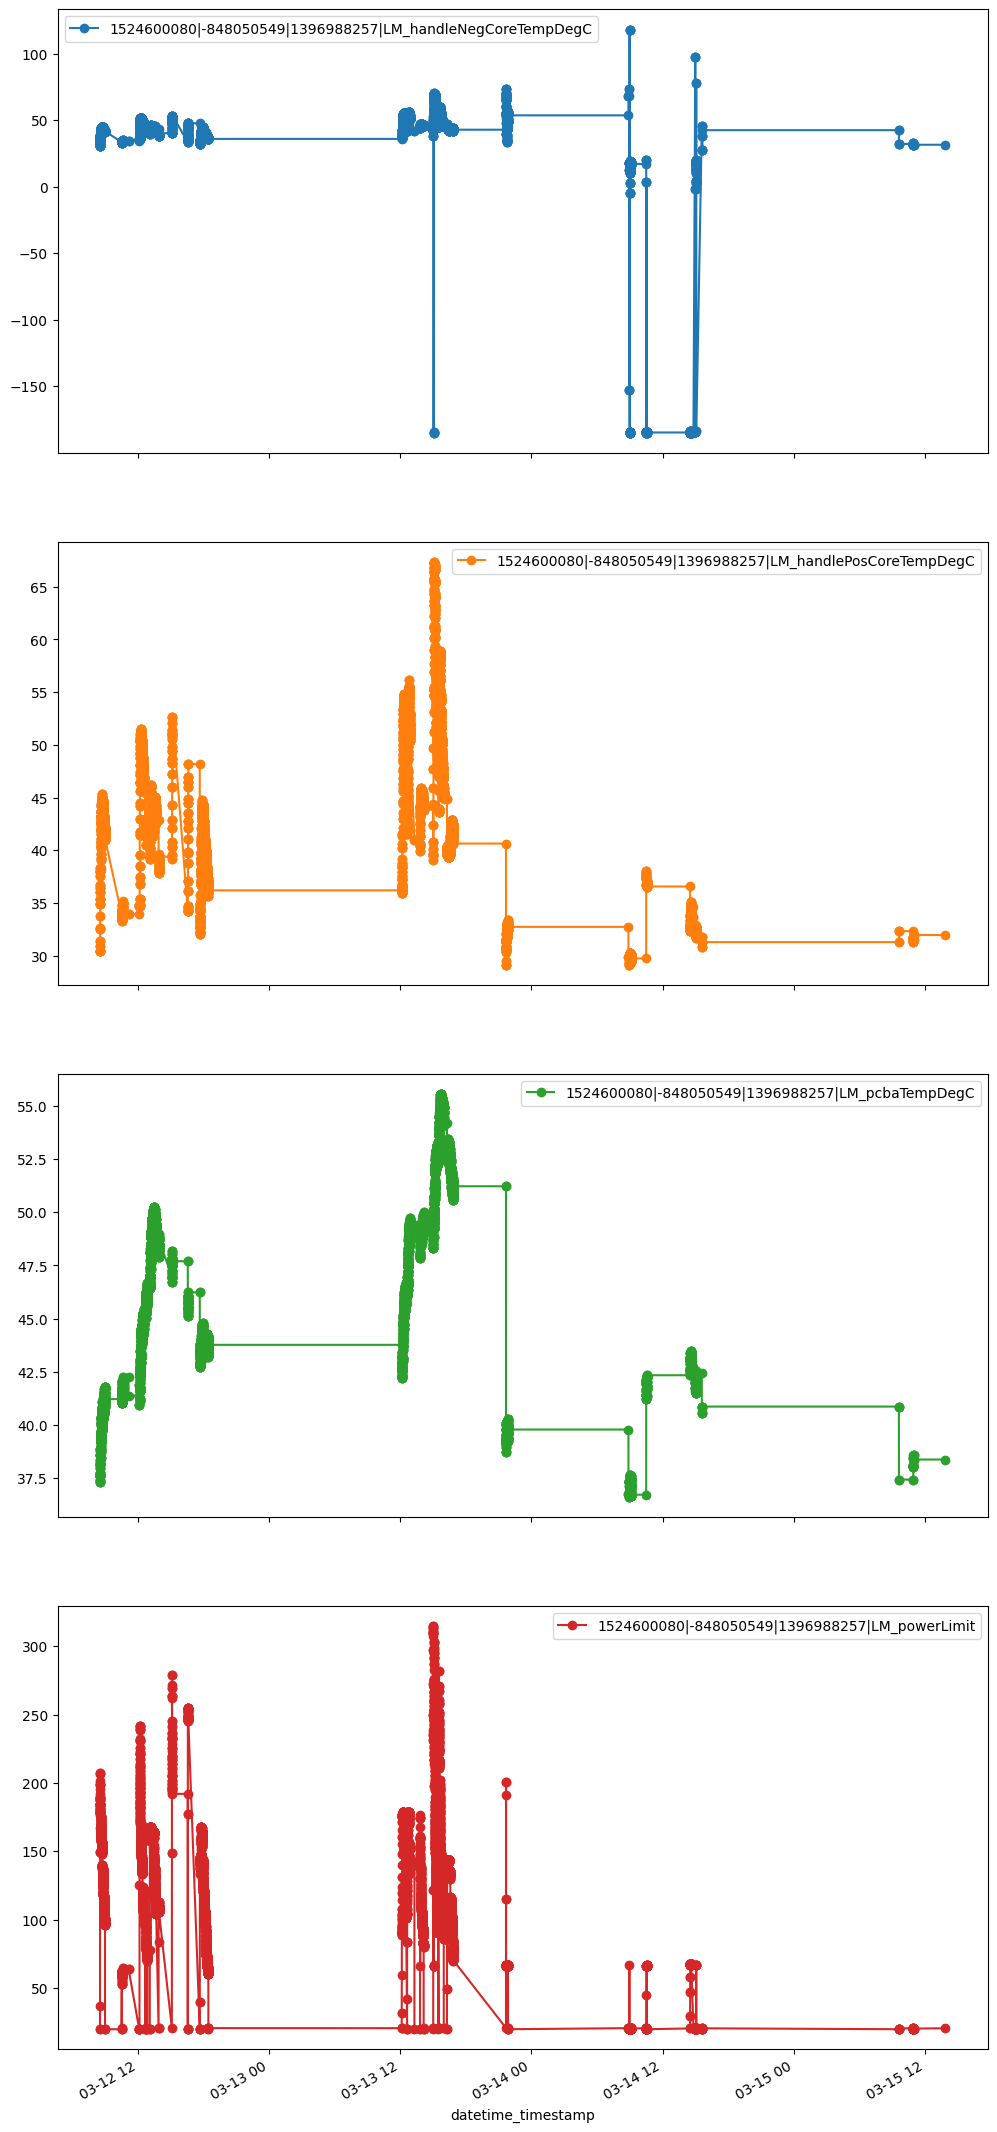

In [11]:
example_component_df = signal_df[
      (signal_df['SITE']==1524600080) 
    & (signal_df['ASSET']==-848050549)
    & (signal_df['COMPONENT']==1396988257)
]

pd.pivot_table(example_component_df,
               index='datetime_timestamp', 
               columns=['unique_signal'],

               values='VALUE').ffill().plot(subplots=True, marker="o", figsize=(12,30))

Very negative temperatures are happening randomly. This could be a sign of a bad connection, and is worth flagging, however, we should be careful doing math with these values because they are most likely extremely wrong. Having the option to use them or throw them out is probably helpful. I've implemented clean_temperature_data() to do this.

array([<AxesSubplot:xlabel='datetime_timestamp'>], dtype=object)

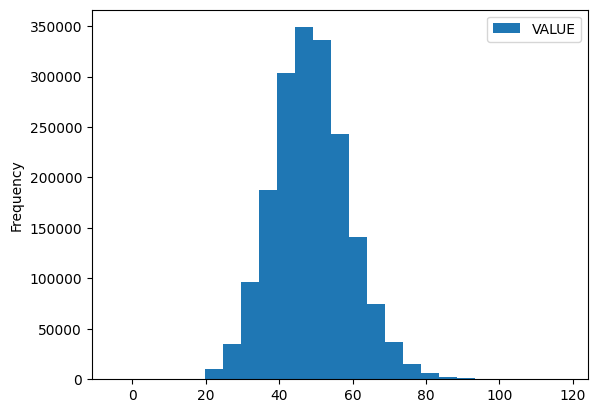

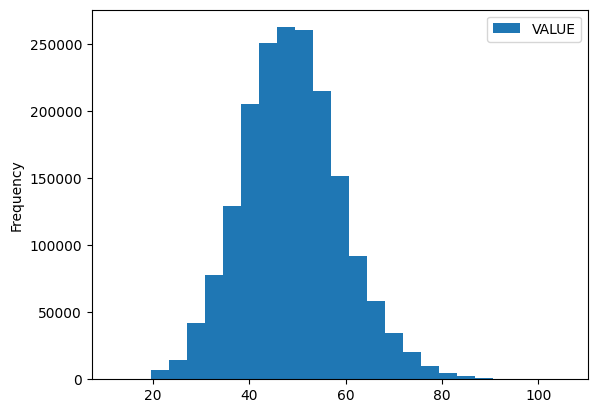

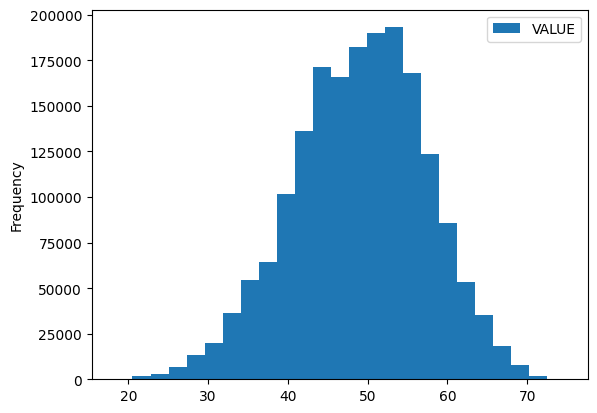

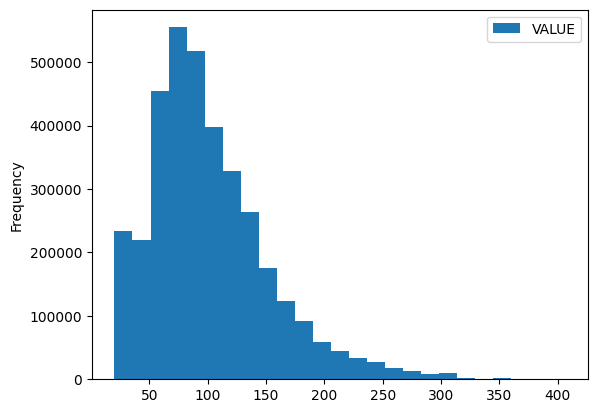

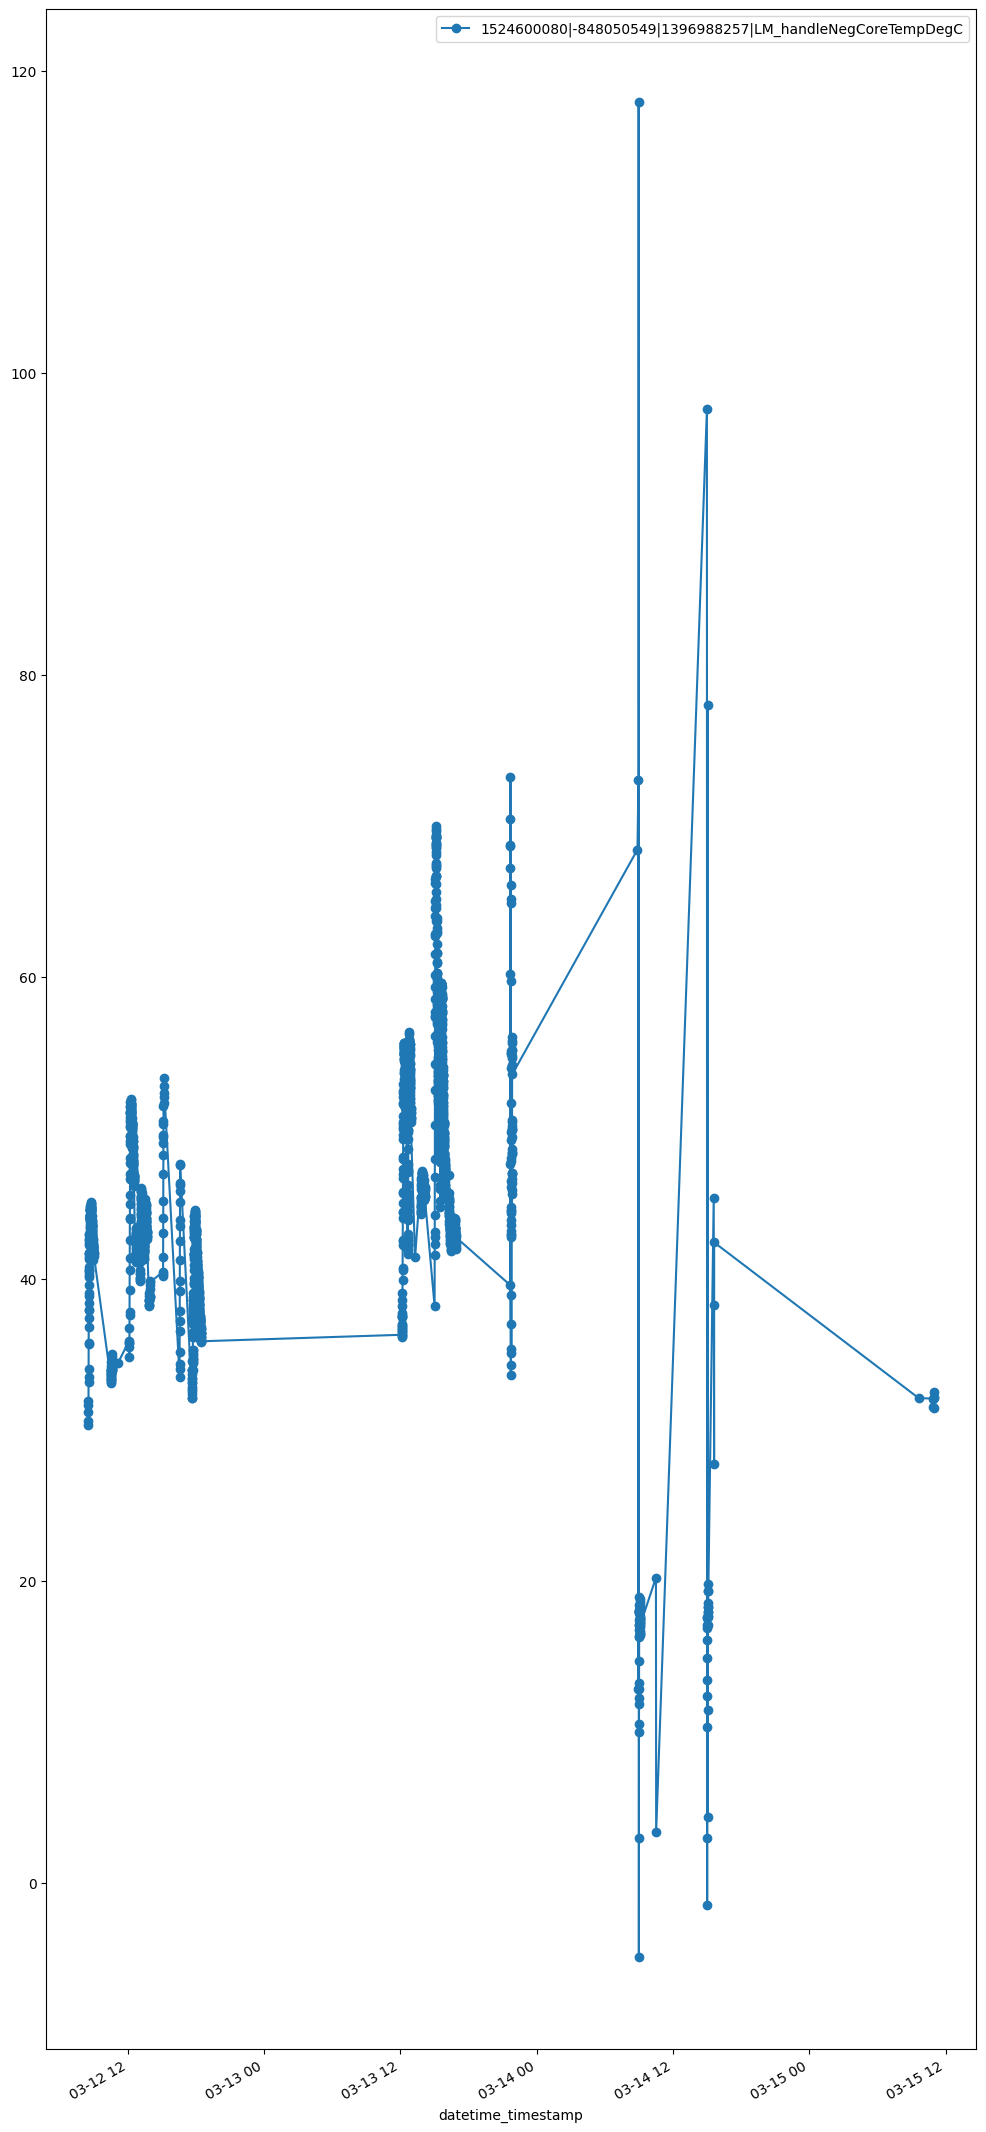

In [12]:
# Evaluate how the clean_temperature_data() function works for histograms as well as time plots.

cleaned_df = helper.clean_temperature_data(signal_df)

# Now repeat the histograms to see the improvement
cleaned_df[['signal_name','VALUE']].groupby('signal_name').plot.hist(by='VALUE', bins=25)

# Also plot the cleaned temperature for the affected handle
example_component_df = cleaned_df[
      (signal_df['SITE'] == 1524600080) 
    & (signal_df['ASSET'] == -848050549)
    & (signal_df['COMPONENT'] == 1396988257)
    & (signal_df['signal_name'] == 'LM_handleNegCoreTempDegC')
]
pd.pivot_table(example_component_df,
               index='datetime_timestamp', 
               columns=['unique_signal'],
               values='VALUE').ffill().plot(subplots=True, marker="o", figsize=(12,30))

Although we have positive jumps approaching 120 degC as well, these are potentially possible values, and the questions ask for times where the temperature exceeds 105 degC. Even though it seems unlikely we could have such instantaneous jumps of ~40 degC without Megawatts of powerflow, I'll leave these positive jumps as is and not attempt to apply any filtering logic as it will disrupt the actual data evaluation.